In [15]:
SEGMENTATION_PATH = "/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv"
TRAIN_PATH = "/kaggle/input/airbus-ship-detection/train_v2/"
TEST_PATH = "/kaggle/input/airbus-ship-detection/test_v2/"

In [16]:
segmentation_df = pd.read_csv(SEGMENTATION_PATH)

In [17]:
segmentation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [18]:
shape = (768, 768) #image shape according to info about dataset

In [19]:
corrupted_images = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] 

# List of corrupted images found at dataset discussions

corrupted_images_present = segmentation_df[segmentation_df['ImageId'].isin(corrupted_images)]

# As we see only one corrupted image is present
corrupted_images_present

,ImageId,EncodedPixels
90158,6384c3e78.jpg,NaN


In [20]:
# drop corrupted
segmentation_df = segmentation_df.drop(corrupted_images_present.index) 
segmentation_df[segmentation_df['ImageId'].isin(corrupted_images)]

,ImageId,EncodedPixels


In [21]:
def plot_combined_visualizations(ships_numbers):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Histogram
    ax[0].hist(ships_numbers, bins=15)
    ax[0].set_title('Distribution of number of ships')

    # Pie chart
    percentages = (ships_count.value_counts() / ships_count.value_counts().sum()) * 100
    
    labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(ships_numbers.value_counts().index, percentages)]
    
    ax[1].pie(ships_numbers.value_counts(), labels=None)
    ax[1].legend(labels, bbox_to_anchor=(1., 1.), fontsize=14)
    ax[1].yaxis.set_visible(False)
    ax[1].set_title('Distribution number of ships')

    plt.show()

In [22]:
#Distribution of number of ships on image
ships_count = segmentation_df['ImageId'].value_counts()
ships_count[segmentation_df['ImageId'].loc[segmentation_df['EncodedPixels'].isna()]] = 0
ships_count.value_counts()

count
0     149999
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64

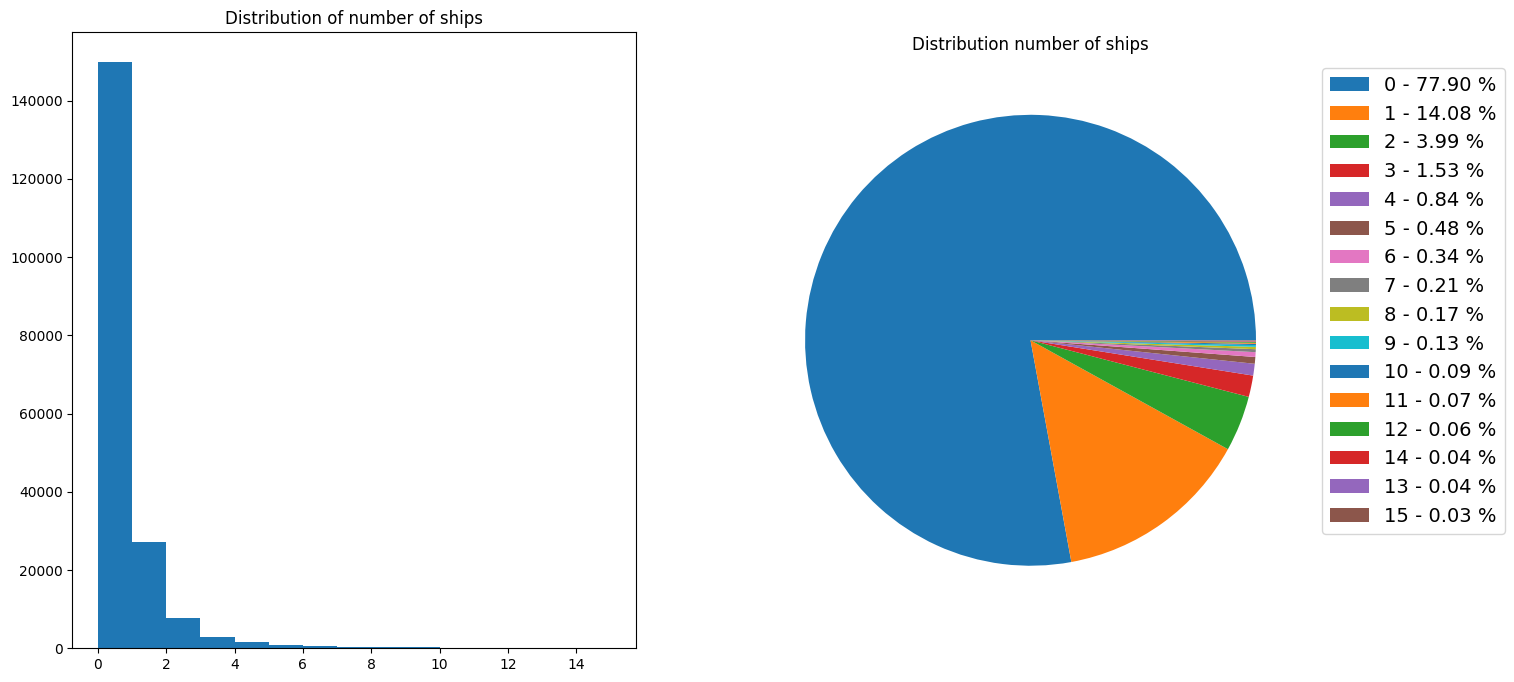

In [23]:
plot_combined_visualizations(ships_count)
# As we see dataset is higly unbalanced, most images contains no ships - and so nearly no 
# information usefull to train segmentation model. Thats why it will usefull to balance this images.

In [24]:
#Balancing dataset by reducing images with zero ships to 10% of initial number
rows_with_nan = segmentation_df[segmentation_df['EncodedPixels'].isnull()]
random_sample_indexes = rows_with_nan.sample(frac=0.90).index
balanced_segmentation_df = segmentation_df.drop(random_sample_indexes)

In [25]:
balanced_segmentation_df

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
231708,fffc6b811.jpg,NaN
231709,fffcb6464.jpg,222782 4 223550 10 224318 14 225086 14 225854 ...
231712,fffd924fb.jpg,110011 5 110779 5 111547 5 112315 5 113083 5 1...
231713,fffd924fb.jpg,198440 8 199208 8 199976 8 200744 8 201512 8 2...


In [26]:
ships_count = balanced_segmentation_df['ImageId'].value_counts()
ships_count[balanced_segmentation_df['ImageId'].loc[balanced_segmentation_df['EncodedPixels'].isna()]] = 0
ships_count.value_counts()

count
1     27104
0     15000
2      7674
3      2954
4      1622
5       925
6       657
7       406
8       318
9       243
10      168
11      144
12      124
14       76
13       75
15       66
Name: count, dtype: int64

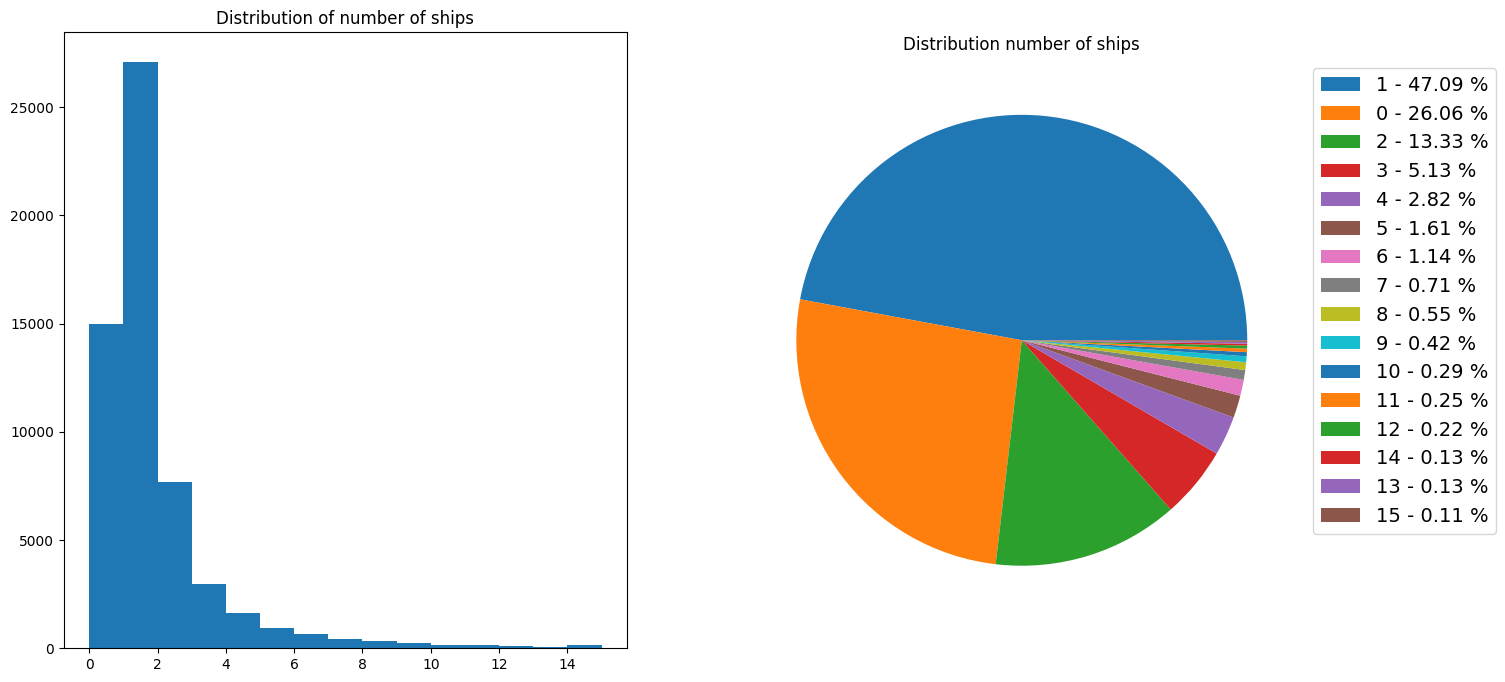

In [27]:
plot_combined_visualizations(ships_count)

In [28]:
#finding ship area percentage on image

def pixels_percentage(encoded_pixels, shape):
    
    if pd.isnull(encoded_pixels):
        return 0
    
    pixels_number = np.array(encoded_pixels.split()[1::2], dtype=int).sum()
    
    return pixels_number / (shape[0] * shape[1])

balanced_segmentation_df['ShipAreaPercentage'] = balanced_segmentation_df['EncodedPixels'].apply(lambda x: pixels_percentage(x, shape))

In [29]:
print('mean:', balanced_segmentation_df['ShipAreaPercentage'].mean())
print('std:', balanced_segmentation_df['ShipAreaPercentage'].std())
print('max:', balanced_segmentation_df['ShipAreaPercentage'].max())

# Individual ship area reaches max 4.4% from total image area

mean: 0.0022452915104975734
std: 0.004532410687700505
max: 0.04391818576388889


In [32]:
def get_mask(image_id, shape):
    shape = (768, 768)
    rows = segmentation_df[segmentation_df['ImageId'] == image_id]
    
    ships_count = len(rows)
    mask = np.zeros((shape[0] * shape[1]), dtype=np.uint8)
    
    for i in range(ships_count):
        encoded_mask = rows.iloc[i]['EncodedPixels']
        
        if isinstance(encoded_mask, float):  # Check for NaN values
            return mask.reshape((shape[0], shape[1], 1))
        encoded_mask = np.array(encoded_mask.split(), dtype=int)
        
        rle_data = np.reshape(encoded_mask, (-1, 2))
        
        for pixel, shift in rle_data:
            mask[pixel-1:pixel+shift] = 255
            
    
    return mask.reshape((1, shape[1], shape[0])).T

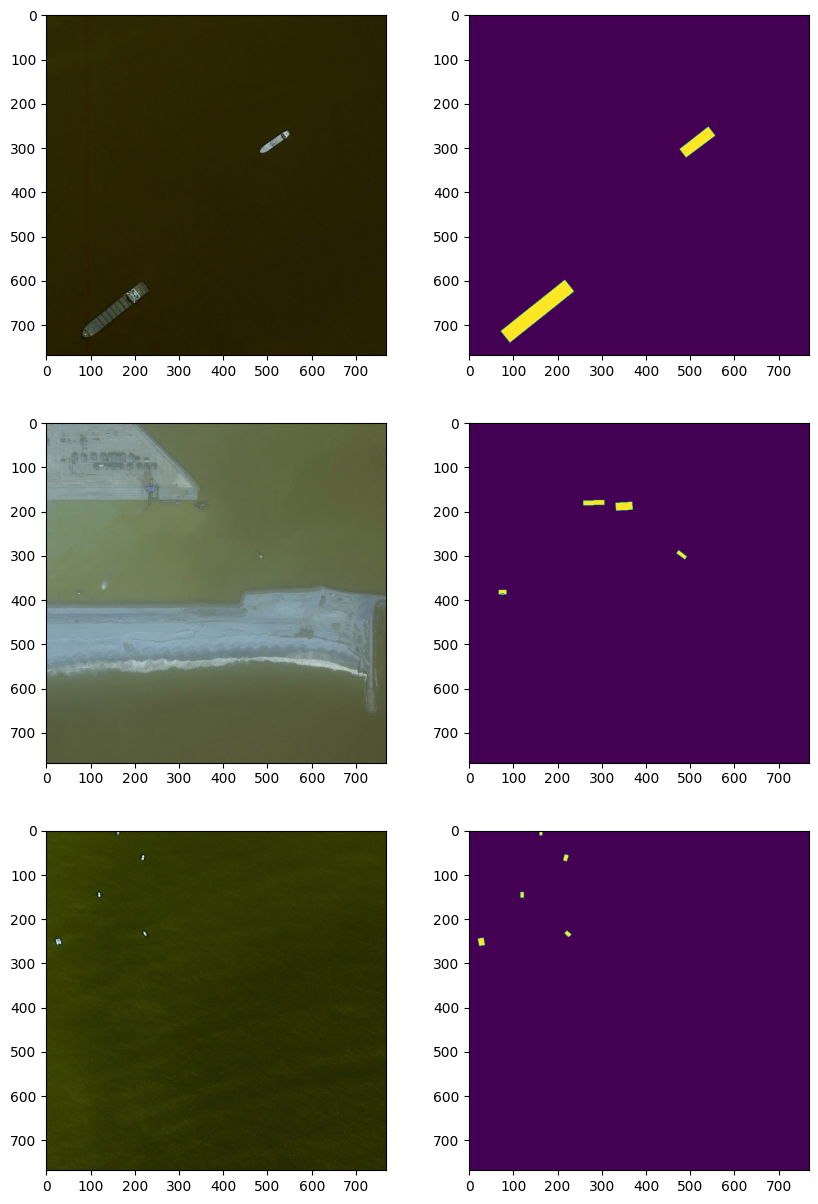

In [33]:
path1 = balanced_segmentation_df['ImageId'][29]
path2 = balanced_segmentation_df['ImageId'][4]
path3 = balanced_segmentation_df['ImageId'][238]

image1 = cv2.imread(TRAIN_PATH + path1)
image2 = cv2.imread(TRAIN_PATH + path2)
image3 = cv2.imread(TRAIN_PATH + path3)

mask1 = get_mask(path1, shape)
mask2 = get_mask(path2, shape)
mask3 = get_mask(path3, shape)

f,ax = plt.subplots(3, 2, figsize=(10, 5 * 3))
ax[0][0].imshow(image1)
ax[0][1].imshow(mask1)
ax[1][0].imshow(image2)
ax[1][1].imshow(mask2)
ax[2][0].imshow(image3)
ax[2][1].imshow(mask3)
plt.show()



# Conclusion

Upon examining the dataset, I noticed a significant imbalance. Even after addressing the lack of ship instances in some images, the challenge of a small ship area percentage persists. This imbalance can greatly impact training when using standard loss functions. To mitigate this, specialized loss functions are necessary, ones that aren't influenced by such disproportions. Consequently, loss functions based on intersection over union (IoU) and Dice scores, like IOU and DICE loss, present viable options to address this issue. Careful consideration is necessary when applying scaling to  images, as it can significantly diminish critical mask information due to their size. 